In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
#from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
import numpy as np
import os
#import cv2
from glob import glob
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from IPython.display import Image

In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
from itertools import cycle
#from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

In [3]:
import sys
import tensorflow as tf
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib


print(f"Python {sys.version}")
print()
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")
print()
print(f"Pandas: {pd.__version__}")
print(f"Scikit-Learn: {sk.__version__}")
print(f"Numpy: {np.__version__}")
print(f"Matplotlib: {matplotlib.__version__}")
print()
print("GPU is ", "available" if tf.config.list_physical_devices('GPU') else "not available")
print(f"CUDA: {tf.test.is_built_with_cuda()}")

Python 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]

Tensorflow version: 2.9.1
Keras Version: 2.9.0

Pandas: 1.4.2
Scikit-Learn: 1.0.2
Numpy: 1.21.5
Matplotlib: 3.5.1

GPU is  available
CUDA: True


In [4]:
!nvidia-smi

Sun Jul  3 09:47:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.40       Driver Version: 516.40       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   43C    P8    12W /  N/A |      6MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [6]:
train_path = 'D:/MScCS/thesis/Dataset/new1/train'
valid_path = 'D:/MScCS/thesis/Dataset/new1/test'

In [7]:
# Import the VGG16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

vgg16 = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [8]:
# don't train existing weights
for layer in vgg16.layers:
    layer.trainable = False

In [9]:
# useful for getting number of output classes
folders = glob('D:/MScCS/thesis/Dataset/new1/train/*')

In [10]:
folders

['D:/MScCS/thesis/Dataset/new1/train\\cocci',
 'D:/MScCS/thesis/Dataset/new1/train\\healthy',
 'D:/MScCS/thesis/Dataset/new1/train\\ncd',
 'D:/MScCS/thesis/Dataset/new1/train\\salmo']

In [11]:
#layers
x = Flatten()(vgg16.output)

In [12]:
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg16.input, outputs=prediction)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer=optimizer,
  metrics=['accuracy', tf.keras.metrics.AUC()]
)

In [15]:
# Use the Image Data Generator to import the images from the dataset
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   rotation_range= 15,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [16]:
training_set = train_datagen.flow_from_directory('D:/MScCS/thesis/Dataset/new1/train',
                                                 target_size = (224, 224),
                                                 batch_size = 8,
                                                 class_mode = 'categorical')

Found 748 images belonging to 4 classes.


In [17]:
test_set = test_datagen.flow_from_directory('D:/MScCS/thesis/Dataset/new1/test',
                                            target_size = (224, 224),
                                            batch_size = 8,
                                            class_mode = 'categorical')


Found 252 images belonging to 4 classes.


In [18]:
itr = test_datagen.flow_from_directory(
'D:/MScCS/thesis/Dataset/new1/test',
target_size=(224,224),
batch_size=8,
class_mode='categorical')

#X, y = itr.next()
x_test, y_test = itr.next()

n_classes = 4
lw = 2

Found 252 images belonging to 4 classes.


In [19]:
def plot_roc_curve():
    #roc curve plot

    y_score = model.predict(x_test)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue", "green"])
    for i, color in zip(range(n_classes), colors):
        if(i == 0):
            plt.plot(
                fpr[i],
                tpr[i],
                color=color,
                lw=lw,
                label="ROC curve of cocci (area = {1:0.2f})".format(i, roc_auc[i]),
            )
        if(i == 1):
            plt.plot(
                fpr[i],
                tpr[i],
                color=color,
                lw=lw,
                label="ROC curve of healthy (area = {1:0.2f})".format(i, roc_auc[i]),
            )
        if(i == 2):
            plt.plot(
                fpr[i],
                tpr[i],
                color=color,
                lw=lw,
                label="ROC curve of ncd (area = {1:0.2f})".format(i, roc_auc[i]),
            )
        if(i == 3):
            plt.plot(
                fpr[i],
                tpr[i],
                color=color,
                lw=lw,
                label="ROC curve of salmo (area = {1:0.2f})".format(i, roc_auc[i]),
            )
    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic to multiclass")
    plt.legend(loc="lower right")
    plt.show()


In [20]:
def plot_loss_acc():
    # plotting the loss
    plt.plot(r.history['loss'], label='train loss')
    plt.plot(r.history['val_loss'], label='val loss')
    plt.legend()
    plt.ylim(-0.05, 1.1)
    plt.show()

    # plotting the accuracy
    plt.plot(r.history['accuracy'], label='train accuracy')
    plt.plot(r.history['val_accuracy'], label='val accuracy')
    plt.legend()
    plt.ylim(-0.05, 1.1)
    plt.show()

In [18]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/10
94/94 [==============================] - 50s 415ms/step - loss: 0.9663 - accuracy: 0.6430 - auc: 0.8600 - val_loss: 0.7656 - val_accuracy: 0.7222 - val_auc: 0.9173
Epoch 2/10
94/94 [==============================] - 34s 360ms/step - loss: 0.6173 - accuracy: 0.7928 - auc: 0.9508 - val_loss: 0.5852 - val_accuracy: 0.8214 - val_auc: 0.9496
Epoch 3/10
94/94 [==============================] - 34s 361ms/step - loss: 0.5033 - accuracy: 0.8436 - auc: 0.9674 - val_loss: 0.5189 - val_accuracy: 0.8333 - val_auc: 0.9603
Epoch 4/10
94/94 [==============================] - 34s 360ms/step - loss: 0.4435 - accuracy: 0.8663 - auc: 0.9740 - val_loss: 0.4911 - val_accuracy: 0.8413 - val_auc: 0.9589
Epoch 5/10
94/94 [==============================] - 34s 362ms/step - loss: 0.3956 - accuracy: 0.8583 - auc: 0.9787 - val_loss: 0.4368 - val_accuracy: 0.8452 - val_auc: 0.9711
Epoch 6/10
94/94 [==============================] - 34s 359ms/step - loss: 0.3745 - accuracy: 0.8837 - auc: 0.9809 - val_loss

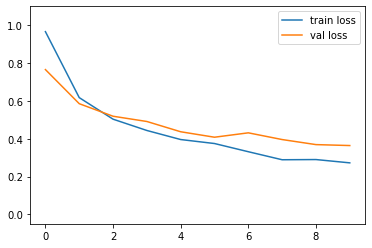

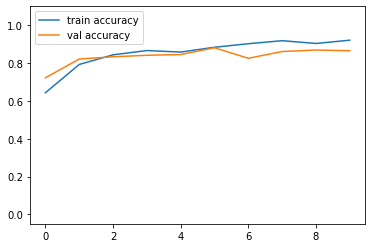

1/1 [==============================] - 0s 146ms/step


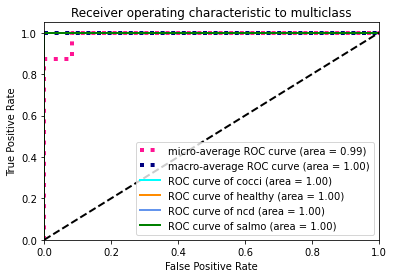

In [22]:
plot_loss_acc()
plot_roc_curve()
model.save('./models/vgg16copy_10.h5')

In [22]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=15,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/15
94/94 [==============================] - 204s 2s/step - loss: 0.9758 - accuracy: 0.5989 - auc: 0.8502 - val_loss: 0.7520 - val_accuracy: 0.7976 - val_auc: 0.9185
Epoch 2/15
94/94 [==============================] - 144s 2s/step - loss: 0.6204 - accuracy: 0.7941 - auc: 0.9510 - val_loss: 0.5838 - val_accuracy: 0.7857 - val_auc: 0.9532
Epoch 3/15
94/94 [==============================] - 150s 2s/step - loss: 0.5217 - accuracy: 0.8128 - auc: 0.9634 - val_loss: 0.4956 - val_accuracy: 0.8611 - val_auc: 0.9655
Epoch 4/15
94/94 [==============================] - 151s 2s/step - loss: 0.4323 - accuracy: 0.8623 - auc: 0.9765 - val_loss: 0.4770 - val_accuracy: 0.8294 - val_auc: 0.9654
Epoch 5/15
94/94 [==============================] - 151s 2s/step - loss: 0.3937 - accuracy: 0.8757 - auc: 0.9803 - val_loss: 0.4615 - val_accuracy: 0.8373 - val_auc: 0.9679
Epoch 6/15
94/94 [==============================] - 151s 2s/step - loss: 0.3542 - accuracy: 0.8904 - auc: 0.9847 - val_loss: 0.4234 - v

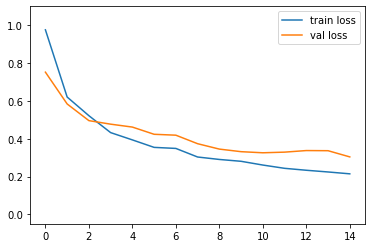

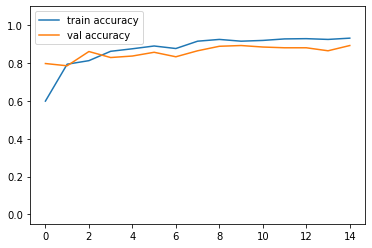

1/1 [==============================] - 1s 681ms/step


C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


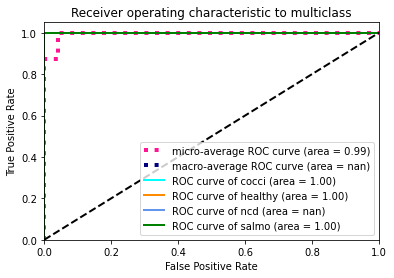

In [23]:
plot_loss_acc()
plot_roc_curve()
model.save('./models/vgg16copy_15.h5')

In [23]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/20
94/94 [==============================] - 34s 363ms/step - loss: 0.2496 - accuracy: 0.9372 - auc: 0.9930 - val_loss: 0.3606 - val_accuracy: 0.8690 - val_auc: 0.9780
Epoch 2/20
94/94 [==============================] - 34s 364ms/step - loss: 0.2409 - accuracy: 0.9412 - auc: 0.9935 - val_loss: 0.3160 - val_accuracy: 0.9087 - val_auc: 0.9833
Epoch 3/20
94/94 [==============================] - 35s 370ms/step - loss: 0.2452 - accuracy: 0.9305 - auc: 0.9924 - val_loss: 0.3299 - val_accuracy: 0.8770 - val_auc: 0.9822
Epoch 4/20
94/94 [==============================] - 34s 361ms/step - loss: 0.2197 - accuracy: 0.9412 - auc: 0.9944 - val_loss: 0.3436 - val_accuracy: 0.8532 - val_auc: 0.9800
Epoch 5/20
94/94 [==============================] - 34s 362ms/step - loss: 0.2251 - accuracy: 0.9291 - auc: 0.9935 - val_loss: 0.3683 - val_accuracy: 0.8492 - val_auc: 0.9768
Epoch 6/20
94/94 [==============================] - 34s 363ms/step - loss: 0.1847 - accuracy: 0.9519 - auc: 0.9960 - val_loss

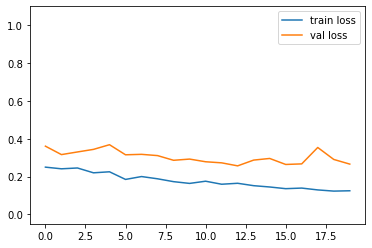

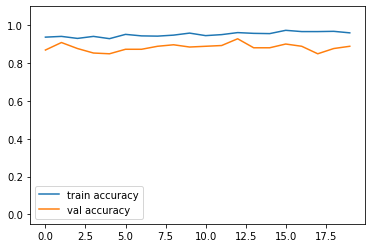

1/1 [==============================] - 0s 26ms/step


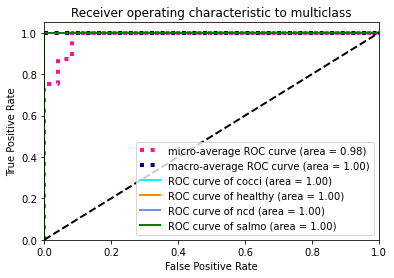

In [24]:
plot_loss_acc()
plot_roc_curve()
model.save('./models/vgg16copy_20.h5')

In [24]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=25,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/25
94/94 [==============================] - 152s 2s/step - loss: 0.2071 - accuracy: 0.9318 - auc: 0.9950 - val_loss: 0.2944 - val_accuracy: 0.9048 - val_auc: 0.9855
Epoch 2/25
94/94 [==============================] - 151s 2s/step - loss: 0.1917 - accuracy: 0.9425 - auc: 0.9959 - val_loss: 0.3855 - val_accuracy: 0.8452 - val_auc: 0.9741
Epoch 3/25
94/94 [==============================] - 151s 2s/step - loss: 0.1909 - accuracy: 0.9479 - auc: 0.9957 - val_loss: 0.2799 - val_accuracy: 0.9127 - val_auc: 0.9874
Epoch 4/25
94/94 [==============================] - 151s 2s/step - loss: 0.1782 - accuracy: 0.9519 - auc: 0.9968 - val_loss: 0.3000 - val_accuracy: 0.8770 - val_auc: 0.9849
Epoch 5/25
94/94 [==============================] - 154s 2s/step - loss: 0.1761 - accuracy: 0.9479 - auc: 0.9968 - val_loss: 0.2897 - val_accuracy: 0.8849 - val_auc: 0.9862
Epoch 6/25
94/94 [==============================] - 151s 2s/step - loss: 0.1671 - accuracy: 0.9559 - auc: 0.9974 - val_loss: 0.3210 - v

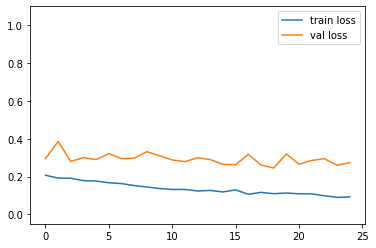

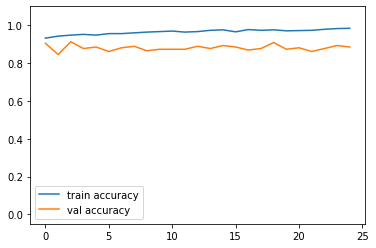

1/1 [==============================] - 0s 49ms/step


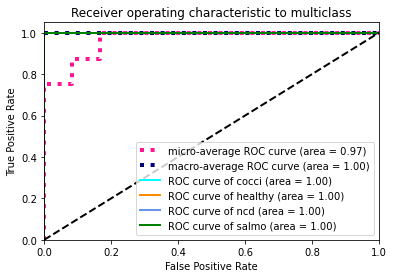

In [28]:
plot_loss_acc()
plot_roc_curve()
model.save('./models/vgg16copy_25.h5')

In [25]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=30,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/30
94/94 [==============================] - 35s 368ms/step - loss: 0.1175 - accuracy: 0.9639 - auc: 0.9989 - val_loss: 0.3658 - val_accuracy: 0.8294 - val_auc: 0.9757
Epoch 2/30
94/94 [==============================] - 34s 360ms/step - loss: 0.1130 - accuracy: 0.9706 - auc: 0.9990 - val_loss: 0.2945 - val_accuracy: 0.8651 - val_auc: 0.9845
Epoch 3/30
94/94 [==============================] - 34s 361ms/step - loss: 0.1132 - accuracy: 0.9719 - auc: 0.9990 - val_loss: 0.2926 - val_accuracy: 0.8730 - val_auc: 0.9847
Epoch 4/30
94/94 [==============================] - 34s 361ms/step - loss: 0.1158 - accuracy: 0.9706 - auc: 0.9987 - val_loss: 0.2824 - val_accuracy: 0.8889 - val_auc: 0.9859
Epoch 5/30
94/94 [==============================] - 34s 358ms/step - loss: 0.1019 - accuracy: 0.9840 - auc: 0.9991 - val_loss: 0.2781 - val_accuracy: 0.8651 - val_auc: 0.9859
Epoch 6/30
94/94 [==============================] - 34s 361ms/step - loss: 0.1008 - accuracy: 0.9786 - auc: 0.9992 - val_loss

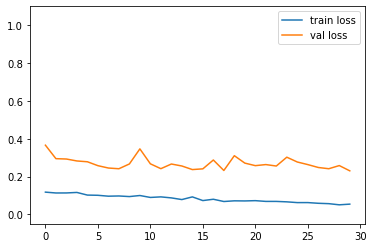

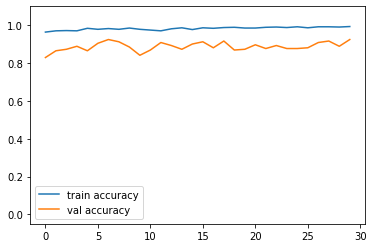

1/1 [==============================] - 0s 25ms/step


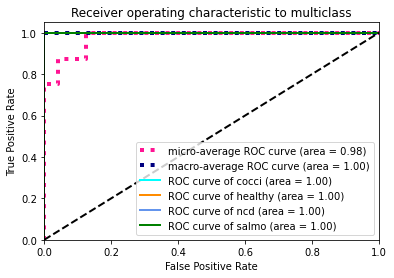

In [26]:
plot_loss_acc()
plot_roc_curve()
model.save('./models/vgg16copy_30.h5')

In [27]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=35,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/35
94/94 [==============================] - 35s 372ms/step - loss: 0.0518 - accuracy: 0.9947 - auc: 1.0000 - val_loss: 0.2774 - val_accuracy: 0.8770 - val_auc: 0.9870
Epoch 2/35
94/94 [==============================] - 62s 659ms/step - loss: 0.0500 - accuracy: 0.9906 - auc: 0.9999 - val_loss: 0.2602 - val_accuracy: 0.9048 - val_auc: 0.9882
Epoch 3/35
94/94 [==============================] - 40s 425ms/step - loss: 0.0537 - accuracy: 0.9906 - auc: 0.9999 - val_loss: 0.2953 - val_accuracy: 0.8651 - val_auc: 0.9854
Epoch 4/35
94/94 [==============================] - 36s 379ms/step - loss: 0.0481 - accuracy: 0.9960 - auc: 1.0000 - val_loss: 0.2841 - val_accuracy: 0.8770 - val_auc: 0.9861
Epoch 5/35
94/94 [==============================] - 35s 372ms/step - loss: 0.0466 - accuracy: 0.9947 - auc: 1.0000 - val_loss: 0.2539 - val_accuracy: 0.8929 - val_auc: 0.9885
Epoch 6/35
94/94 [==============================] - 35s 372ms/step - loss: 0.0555 - accuracy: 0.9893 - auc: 0.9999 - val_loss

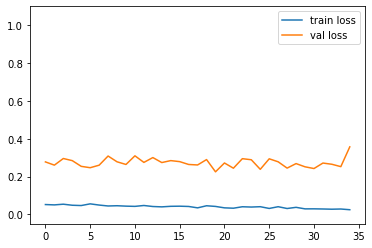

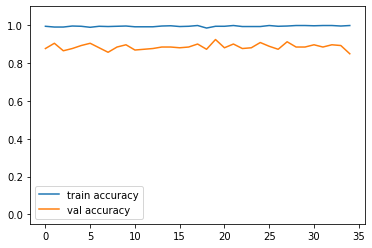

1/1 [==============================] - 0s 32ms/step


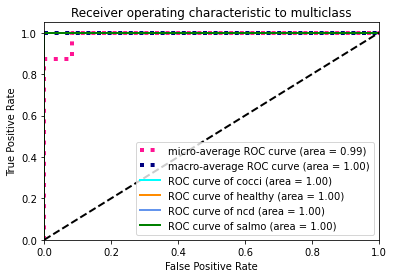

In [28]:
plot_loss_acc()
plot_roc_curve()
model.save('./models/vgg16copy_35.h5')

In [29]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=40,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/40
94/94 [==============================] - 46s 493ms/step - loss: 0.0948 - accuracy: 0.9746 - auc: 0.9993 - val_loss: 0.2708 - val_accuracy: 0.8571 - val_auc: 0.9866
Epoch 2/40
94/94 [==============================] - 46s 495ms/step - loss: 0.0806 - accuracy: 0.9880 - auc: 0.9997 - val_loss: 0.2503 - val_accuracy: 0.8810 - val_auc: 0.9885
Epoch 3/40
94/94 [==============================] - 47s 500ms/step - loss: 0.0832 - accuracy: 0.9826 - auc: 0.9995 - val_loss: 0.2252 - val_accuracy: 0.9206 - val_auc: 0.9905
Epoch 4/40
94/94 [==============================] - 46s 496ms/step - loss: 0.0902 - accuracy: 0.9773 - auc: 0.9995 - val_loss: 0.2745 - val_accuracy: 0.8651 - val_auc: 0.9863
Epoch 5/40
94/94 [==============================] - 46s 492ms/step - loss: 0.0740 - accuracy: 0.9866 - auc: 0.9998 - val_loss: 0.2664 - val_accuracy: 0.8770 - val_auc: 0.9871
Epoch 6/40
94/94 [==============================] - 46s 492ms/step - loss: 0.0811 - accuracy: 0.9773 - auc: 0.9996 - val_loss

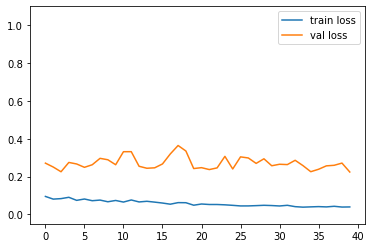

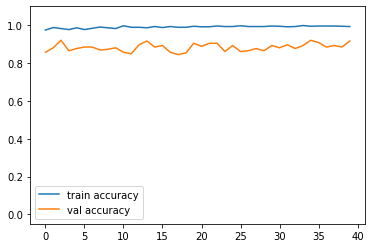

1/1 [==============================] - 0s 30ms/step


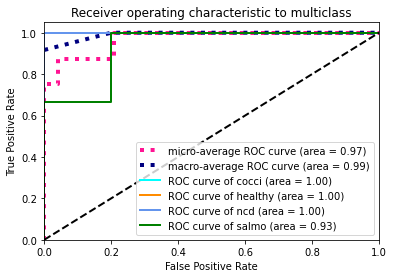

In [30]:
plot_loss_acc()
plot_roc_curve()
model.save('./models/vgg16copy_40.h5')

In [33]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=45,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/45
94/94 [==============================] - 34s 366ms/step - loss: 0.0315 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.2631 - val_accuracy: 0.8810 - val_auc: 0.9888
Epoch 2/45
94/94 [==============================] - 34s 355ms/step - loss: 0.0323 - accuracy: 0.9973 - auc: 1.0000 - val_loss: 0.2542 - val_accuracy: 0.8929 - val_auc: 0.9888
Epoch 3/45
94/94 [==============================] - 33s 357ms/step - loss: 0.0345 - accuracy: 0.9973 - auc: 1.0000 - val_loss: 0.2525 - val_accuracy: 0.8849 - val_auc: 0.9891
Epoch 4/45
94/94 [==============================] - 33s 356ms/step - loss: 0.0378 - accuracy: 0.9933 - auc: 0.9999 - val_loss: 0.2785 - val_accuracy: 0.8849 - val_auc: 0.9875
Epoch 5/45
94/94 [==============================] - 33s 356ms/step - loss: 0.0306 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.3054 - val_accuracy: 0.8611 - val_auc: 0.9842
Epoch 6/45
94/94 [==============================] - 33s 356ms/step - loss: 0.0310 - accuracy: 0.9973 - auc: 1.0000 - val_loss

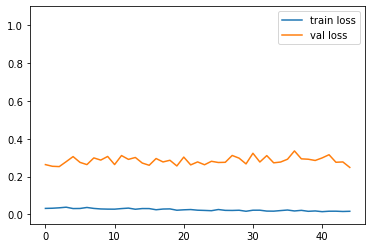

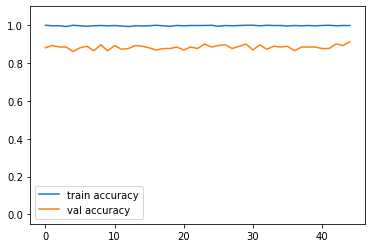

1/1 [==============================] - 0s 26ms/step


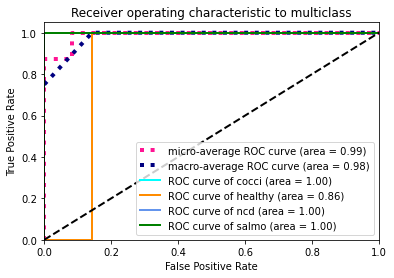

In [37]:
plot_loss_acc()
plot_roc_curve()
model.save('./models/vgg16copy_45.h5')

In [38]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/50
94/94 [==============================] - 34s 363ms/step - loss: 0.0185 - accuracy: 0.9987 - auc: 1.0000 - val_loss: 0.2802 - val_accuracy: 0.8810 - val_auc: 0.9875
Epoch 2/50
94/94 [==============================] - 33s 354ms/step - loss: 0.0169 - accuracy: 0.9973 - auc: 1.0000 - val_loss: 0.2572 - val_accuracy: 0.9127 - val_auc: 0.9903
Epoch 3/50
94/94 [==============================] - 33s 356ms/step - loss: 0.0143 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.2600 - val_accuracy: 0.9127 - val_auc: 0.9886
Epoch 4/50
94/94 [==============================] - 33s 356ms/step - loss: 0.0182 - accuracy: 0.9973 - auc: 1.0000 - val_loss: 0.2399 - val_accuracy: 0.9008 - val_auc: 0.9893
Epoch 5/50
94/94 [==============================] - 33s 356ms/step - loss: 0.0156 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.2813 - val_accuracy: 0.8889 - val_auc: 0.9871
Epoch 6/50
94/94 [==============================] - 33s 356ms/step - loss: 0.0172 - accuracy: 0.9987 - auc: 1.0000 - val_loss

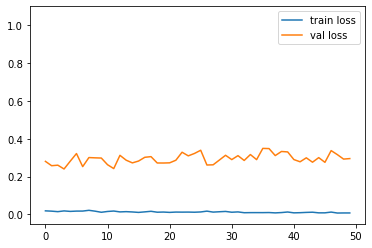

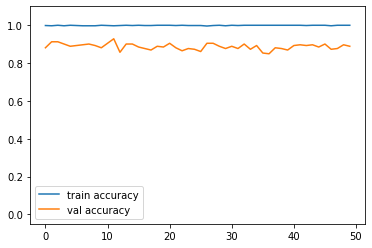

1/1 [==============================] - 0s 24ms/step


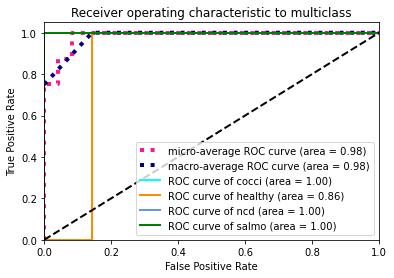

In [39]:
plot_loss_acc()
plot_roc_curve()
model.save('./models/vgg16copy_50.h5')

In [40]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=60,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/60
94/94 [==============================] - 34s 355ms/step - loss: 0.0090 - accuracy: 0.9987 - auc: 1.0000 - val_loss: 0.2799 - val_accuracy: 0.8968 - val_auc: 0.9860
Epoch 2/60
94/94 [==============================] - 33s 354ms/step - loss: 0.0108 - accuracy: 0.9987 - auc: 1.0000 - val_loss: 0.3393 - val_accuracy: 0.8651 - val_auc: 0.9828
Epoch 3/60
94/94 [==============================] - 33s 354ms/step - loss: 0.0062 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.3493 - val_accuracy: 0.8571 - val_auc: 0.9825
Epoch 4/60
94/94 [==============================] - 33s 355ms/step - loss: 0.0088 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.3120 - val_accuracy: 0.8849 - val_auc: 0.9844
Epoch 5/60
94/94 [==============================] - 34s 358ms/step - loss: 0.0078 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.3376 - val_accuracy: 0.8690 - val_auc: 0.9833
Epoch 6/60
94/94 [==============================] - 33s 354ms/step - loss: 0.0074 - accuracy: 1.0000 - auc: 1.0000 - val_loss

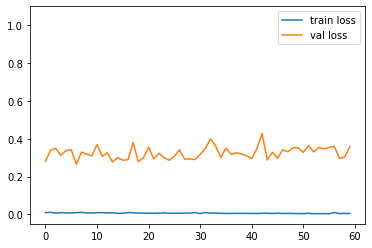

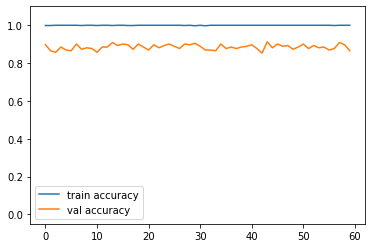

1/1 [==============================] - 0s 25ms/step


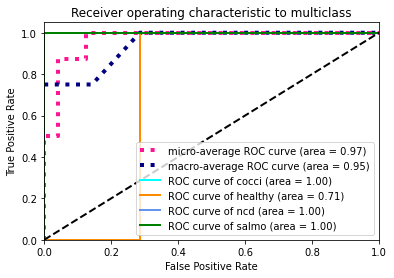

In [41]:
plot_loss_acc()
plot_roc_curve()
model.save('./models/vgg16copy_60.h5')

In [45]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=70,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/70
94/94 [==============================] - 36s 377ms/step - loss: 0.0036 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.3552 - val_accuracy: 0.8770 - val_auc: 0.9796
Epoch 2/70
94/94 [==============================] - 34s 365ms/step - loss: 0.0032 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.3337 - val_accuracy: 0.8810 - val_auc: 0.9802
Epoch 3/70
94/94 [==============================] - 35s 372ms/step - loss: 0.0039 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.3831 - val_accuracy: 0.8611 - val_auc: 0.9783
Epoch 4/70
94/94 [==============================] - 34s 359ms/step - loss: 0.0034 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.3146 - val_accuracy: 0.9008 - val_auc: 0.9854
Epoch 5/70
94/94 [==============================] - 34s 358ms/step - loss: 0.0037 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.3690 - val_accuracy: 0.8651 - val_auc: 0.9785
Epoch 6/70
94/94 [==============================] - 35s 373ms/step - loss: 0.0037 - accuracy: 1.0000 - auc: 1.0000 - val_loss

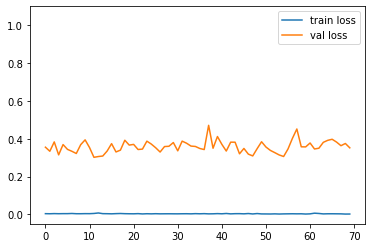

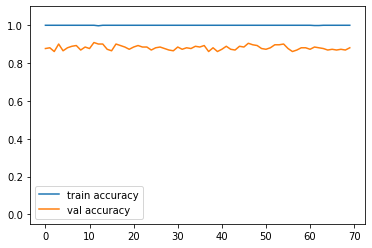

1/1 [==============================] - 0s 46ms/step


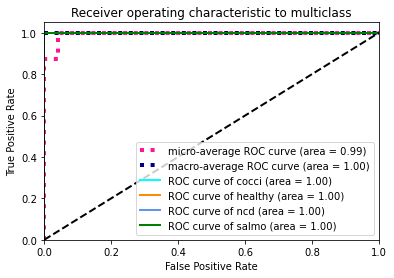

In [49]:
plot_loss_acc()
plot_roc_curve()
model.save('./models/vgg16copy_70.h5')

In [22]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=80,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/80
94/94 [==============================] - 44s 387ms/step - loss: 0.9536 - accuracy: 0.6511 - auc: 0.8679 - val_loss: 0.7528 - val_accuracy: 0.7460 - val_auc: 0.9148
Epoch 2/80
94/94 [==============================] - 34s 357ms/step - loss: 0.5985 - accuracy: 0.8102 - auc: 0.9554 - val_loss: 0.5673 - val_accuracy: 0.8452 - val_auc: 0.9599
Epoch 3/80
94/94 [==============================] - 34s 362ms/step - loss: 0.5051 - accuracy: 0.8396 - auc: 0.9669 - val_loss: 0.5055 - val_accuracy: 0.8254 - val_auc: 0.9630
Epoch 4/80
94/94 [==============================] - 34s 359ms/step - loss: 0.4495 - accuracy: 0.8422 - auc: 0.9718 - val_loss: 0.4646 - val_accuracy: 0.8294 - val_auc: 0.9684
Epoch 5/80
94/94 [==============================] - 34s 359ms/step - loss: 0.3805 - accuracy: 0.8850 - auc: 0.9809 - val_loss: 0.4882 - val_accuracy: 0.8016 - val_auc: 0.9611
Epoch 6/80
94/94 [==============================] - 34s 357ms/step - loss: 0.3479 - accuracy: 0.8917 - auc: 0.9845 - val_loss

94/94 [==============================] - 35s 373ms/step - loss: 0.0774 - accuracy: 0.9840 - auc: 0.9997 - val_loss: 0.2429 - val_accuracy: 0.9008 - val_auc: 0.9893
Epoch 48/80
94/94 [==============================] - 37s 394ms/step - loss: 0.0757 - accuracy: 0.9866 - auc: 0.9996 - val_loss: 0.2294 - val_accuracy: 0.9087 - val_auc: 0.9907
Epoch 49/80
94/94 [==============================] - 37s 397ms/step - loss: 0.0711 - accuracy: 0.9920 - auc: 0.9999 - val_loss: 0.2293 - val_accuracy: 0.9127 - val_auc: 0.9905
Epoch 50/80
94/94 [==============================] - 35s 370ms/step - loss: 0.0703 - accuracy: 0.9853 - auc: 0.9998 - val_loss: 0.2886 - val_accuracy: 0.8532 - val_auc: 0.9859
Epoch 51/80
94/94 [==============================] - 34s 366ms/step - loss: 0.0676 - accuracy: 0.9920 - auc: 0.9998 - val_loss: 0.2754 - val_accuracy: 0.8690 - val_auc: 0.9871
Epoch 52/80
94/94 [==============================] - 34s 357ms/step - loss: 0.0641 - accuracy: 0.9893 - auc: 0.9998 - val_loss: 0.26

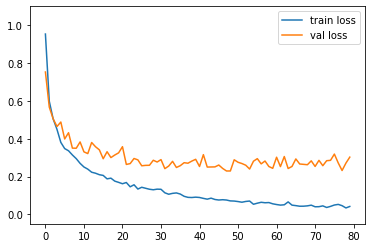

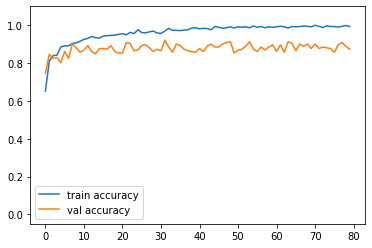

1/1 [==============================] - 0s 25ms/step


C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


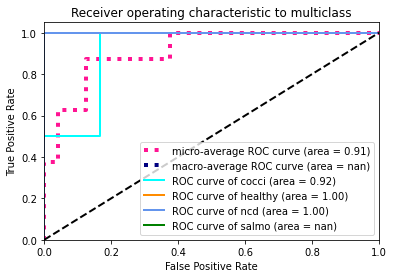

In [27]:
plot_loss_acc()
plot_roc_curve()
model.save('./models/vgg16copy_80.h5')

1/1 [==============================] - 0s 25ms/step


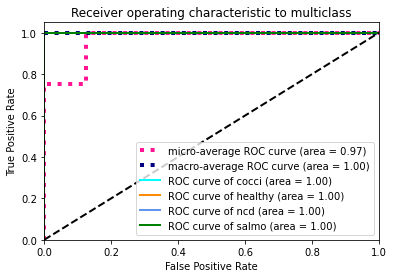

In [30]:
plot_roc_curve()

In [31]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=90,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/90
94/94 [==============================] - 34s 363ms/step - loss: 0.0368 - accuracy: 0.9960 - auc: 1.0000 - val_loss: 0.2767 - val_accuracy: 0.8849 - val_auc: 0.9879
Epoch 2/90
94/94 [==============================] - 34s 358ms/step - loss: 0.0343 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.2616 - val_accuracy: 0.8968 - val_auc: 0.9873
Epoch 3/90
94/94 [==============================] - 34s 358ms/step - loss: 0.0256 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.2895 - val_accuracy: 0.8810 - val_auc: 0.9854
Epoch 4/90
94/94 [==============================] - 34s 358ms/step - loss: 0.0312 - accuracy: 0.9960 - auc: 1.0000 - val_loss: 0.2296 - val_accuracy: 0.9167 - val_auc: 0.9902
Epoch 5/90
94/94 [==============================] - 33s 356ms/step - loss: 0.0317 - accuracy: 0.9933 - auc: 1.0000 - val_loss: 0.2533 - val_accuracy: 0.9048 - val_auc: 0.9892
Epoch 6/90
94/94 [==============================] - 33s 356ms/step - loss: 0.0386 - accuracy: 0.9933 - auc: 0.9999 - val_loss

94/94 [==============================] - 33s 354ms/step - loss: 0.0158 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.3710 - val_accuracy: 0.8730 - val_auc: 0.9778
Epoch 48/90
94/94 [==============================] - 33s 355ms/step - loss: 0.0148 - accuracy: 0.9973 - auc: 1.0000 - val_loss: 0.3124 - val_accuracy: 0.8810 - val_auc: 0.9853
Epoch 49/90
94/94 [==============================] - 33s 354ms/step - loss: 0.0151 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.2859 - val_accuracy: 0.9087 - val_auc: 0.9859
Epoch 50/90
94/94 [==============================] - 33s 356ms/step - loss: 0.0182 - accuracy: 0.9987 - auc: 1.0000 - val_loss: 0.3061 - val_accuracy: 0.8770 - val_auc: 0.9862
Epoch 51/90
94/94 [==============================] - 33s 355ms/step - loss: 0.0172 - accuracy: 0.9973 - auc: 1.0000 - val_loss: 0.2977 - val_accuracy: 0.8770 - val_auc: 0.9865
Epoch 52/90
94/94 [==============================] - 33s 355ms/step - loss: 0.0157 - accuracy: 0.9987 - auc: 1.0000 - val_loss: 0.29

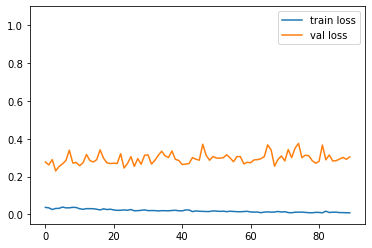

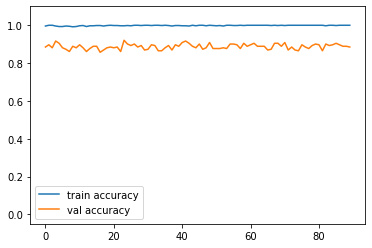

1/1 [==============================] - 0s 25ms/step


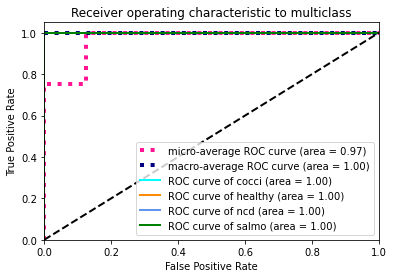

In [32]:
plot_loss_acc()
plot_roc_curve()
model.save('./models/vgg16copy_90.h5')

In [21]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=100,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/100
94/94 [==============================] - 42s 383ms/step - loss: 0.9687 - accuracy: 0.6484 - auc: 0.8655 - val_loss: 0.7215 - val_accuracy: 0.7619 - val_auc: 0.9430
Epoch 2/100
94/94 [==============================] - 49s 528ms/step - loss: 0.6162 - accuracy: 0.7914 - auc: 0.9517 - val_loss: 0.5924 - val_accuracy: 0.7937 - val_auc: 0.9468
Epoch 3/100
94/94 [==============================] - 47s 503ms/step - loss: 0.5081 - accuracy: 0.8275 - auc: 0.9667 - val_loss: 0.5221 - val_accuracy: 0.7976 - val_auc: 0.9593
Epoch 4/100
94/94 [==============================] - 47s 497ms/step - loss: 0.4369 - accuracy: 0.8650 - auc: 0.9762 - val_loss: 0.4774 - val_accuracy: 0.8095 - val_auc: 0.9655
Epoch 5/100
94/94 [==============================] - 47s 498ms/step - loss: 0.4012 - accuracy: 0.8743 - auc: 0.9785 - val_loss: 0.4209 - val_accuracy: 0.8532 - val_auc: 0.9740
Epoch 6/100
94/94 [==============================] - 47s 498ms/step - loss: 0.3666 - accuracy: 0.8877 - auc: 0.9833 - va

94/94 [==============================] - 47s 503ms/step - loss: 0.0789 - accuracy: 0.9813 - auc: 0.9997 - val_loss: 0.2987 - val_accuracy: 0.8730 - val_auc: 0.9848
Epoch 48/100
94/94 [==============================] - 47s 496ms/step - loss: 0.0781 - accuracy: 0.9853 - auc: 0.9996 - val_loss: 0.2307 - val_accuracy: 0.9087 - val_auc: 0.9902
Epoch 49/100
94/94 [==============================] - 47s 501ms/step - loss: 0.0746 - accuracy: 0.9840 - auc: 0.9997 - val_loss: 0.2670 - val_accuracy: 0.9008 - val_auc: 0.9881
Epoch 50/100
94/94 [==============================] - 47s 505ms/step - loss: 0.0718 - accuracy: 0.9853 - auc: 0.9996 - val_loss: 0.2865 - val_accuracy: 0.8651 - val_auc: 0.9862
Epoch 51/100
94/94 [==============================] - 47s 499ms/step - loss: 0.0702 - accuracy: 0.9866 - auc: 0.9997 - val_loss: 0.2784 - val_accuracy: 0.8849 - val_auc: 0.9872
Epoch 52/100
94/94 [==============================] - 47s 506ms/step - loss: 0.0668 - accuracy: 0.9866 - auc: 0.9999 - val_loss:

94/94 [==============================] - 48s 515ms/step - loss: 0.0218 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.2564 - val_accuracy: 0.9048 - val_auc: 0.9896
Epoch 94/100
94/94 [==============================] - 47s 499ms/step - loss: 0.0250 - accuracy: 0.9987 - auc: 1.0000 - val_loss: 0.2595 - val_accuracy: 0.9008 - val_auc: 0.9887
Epoch 95/100
94/94 [==============================] - 49s 518ms/step - loss: 0.0312 - accuracy: 0.9960 - auc: 0.9999 - val_loss: 0.2910 - val_accuracy: 0.8690 - val_auc: 0.9871
Epoch 96/100
94/94 [==============================] - 47s 505ms/step - loss: 0.0251 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.2738 - val_accuracy: 0.8849 - val_auc: 0.9865
Epoch 97/100
94/94 [==============================] - 47s 503ms/step - loss: 0.0259 - accuracy: 0.9973 - auc: 1.0000 - val_loss: 0.2763 - val_accuracy: 0.8810 - val_auc: 0.9865
Epoch 98/100
94/94 [==============================] - 47s 497ms/step - loss: 0.0234 - accuracy: 0.9987 - auc: 1.0000 - val_loss:

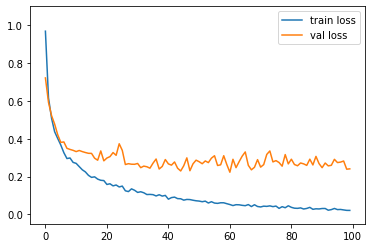

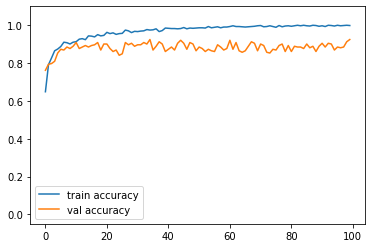

1/1 [==============================] - 0s 231ms/step


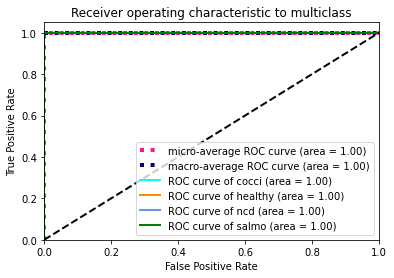

In [22]:
plot_loss_acc()
plot_roc_curve()
model.save('./models/vgg16copy_100.h5')

In [23]:
from sklearn.metrics import confusion_matrix
#cm = confusion_matrix(y_test, y_prob)
y_score = model.predict(x_test)
y_pred=np.argmax(y_score, axis=1)
y_test=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)
print(cm)

1/1 [==============================] - 0s 33ms/step
[[3 0 0 0]
 [0 2 0 0]
 [0 0 1 0]
 [0 0 0 2]]


In [42]:
proba = model.predict(separate_test_set)

5/5 [==============================] - 13s 3s/step


In [48]:
y_probaa = np.argmax(proba, axis=1)
print(y_probaa)

[0 2 3 0 0 2 0 1 1 1 1 1 1 1 1 1 2 2 0 3 0 2 1 0 3 2 1 0 3 1 1 0 0 0 0 0 3
 2 1 1 2 0 1 1 3 3 1 1 1 1 0 2 1 3 1 1 0 0 3 0 0 0 1 1 2 1 1 0 3 0 0 3 2 3
 0 0 3 3 0 3]


In [41]:
separate_test_set = test_datagen.flow_from_directory('D:/MScCS/thesis/Dataset/new/separate testing',
                                            target_size = (224, 224),
                                            batch_size = 16,
                                            class_mode = 'categorical')


Found 80 images belonging to 4 classes.
